<a href="https://colab.research.google.com/github/data-better/ASL/blob/master/11%EA%B0%95_date_formatter_att_no_emb_keras_iynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Original Source:
- https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

### Date Format
[2030-December-12 Thu] -> [12/12/2030, thursday]

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import datetime
from datetime import datetime

tf.enable_eager_execution()

Using TensorFlow backend.


# Data Generation
## functions

In [ ]:
def padding(chars, maxlen):
    if len(chars) < maxlen:
        return chars + '_' * (maxlen - len(chars))
    else:
        return chars[:maxlen]

def gen_date():
    rnd = int(np.random.uniform(low = 1e9, high = 2e9)) # 2001.9.9 ~ 2033.5.18 
    timestamp = datetime.fromtimestamp(rnd)
    return str(timestamp.strftime('%Y-%B-%d %a')) # '%Y-%B-%d %H:%M:%S' ex) 2030-December-12 Thu

    
def format_date(x):
    return str(datetime.strptime(x, '%Y-%B-%d %a').strftime('%m/%d/%Y, %A')).lower() #'%H%M%S:%Y%m%d' ex) 12/12/2030, thursday

  
def gen_test(N):
    q = []
    y = []
    
    for i in range(N):
        question = gen_date()
        answer_y = format_date(question)
        q.append(question)
        y.append(answer_y)
    return(q,y)
  
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

## Generate data

In [ ]:
N = 5000
N_train = int(N * .9)
N_validation = N - N_train

in_seq_len = 32
out_seq_len = 32

added = set()
questions = []
answers = []


while len(questions) < N:
    a = gen_date()
    if a in added:
        continue
    question = '[{}]'.format(a)
    question = padding(question, in_seq_len)
    answer = '[' + str(format_date(a)) + ']'
    answer = padding(answer, out_seq_len)

    added.add(a)
    questions.append(question)
    answers.append(answer)

### Check Data

In [ ]:
print(questions[:3])
print(answers[:3])


['[2012-April-04 Wed]_____________', '[2003-November-27 Thu]__________', '[2011-April-02 Sat]_____________']
['[04/04/2012, wednesday]_________', '[11/27/2003, thursday]__________', '[04/02/2011, saturday]__________']


## One-hot encoding

* vocab_size = 48

In [ ]:
chars = list(set(''.join(questions)))
chars.extend(['[', ']']) # Start and End of Expression
chars.extend(list(set(''.join(answers))))
chars = np.sort(list(set(chars)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

X = np.zeros((len(questions), in_seq_len, len(chars)), dtype='float32')
Y = np.zeros((len(questions), out_seq_len, len(chars)), dtype='float32')

for i in range(N):
    for t, char in enumerate(questions[i]):
        X[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers[i]):
        Y[i, t, char_indices[char]] = 1
       
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, train_size=N_train)

### train data

In [ ]:
print(X_train[0,:,:].shape)
print(question[0])
print(X_train[0,0,:])

(32, 48)
[
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### char_indices

In [ ]:
print(char_indices)

{' ': 0, ',': 1, '-': 2, '/': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'A': 14, 'D': 15, 'F': 16, 'J': 17, 'M': 18, 'N': 19, 'O': 20, 'S': 21, 'T': 22, 'W': 23, '[': 24, ']': 25, '_': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'l': 36, 'm': 37, 'n': 38, 'o': 39, 'p': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'w': 46, 'y': 47}


In [ ]:
tf.test.is_gpu_available()

True

# Model

#### Glorot Uniform Initializer

  - $ u \sim \left[-\sqrt{\frac 6{d_{in} + d_{out}}}, \sqrt{\frac 6{d_{in} + d_{out}}}\right]$

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.gru = tf.keras.layers.CuDNNGRU(self.enc_units,
                      return_sequences = True,
                      return_state = True,
                      recurrent_initializer = 'glorot_uniform' # xavier init
                      )
    
  def call(self, x, hidden): 
    # x: Batch size * in_seq_len * inp_vocab_size
    # hidden: batch_size * enc_units
    output, state = self.gru(x, initial_state = hidden)
    # output: batch_size * in_seq_len * enc_units
    # state: batch * enc_units
    return output, state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))

### Bahdanau Attention

  - Bahdanau alignment score (additive score) = $ v^T \tanh (W_1 h_t + W_2 \bar h_s)$

  - value : $\bar h_s, s = 1, \ldots, $ input sequence length

  - query: $h_t$

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query shape: (batch_size, dec_unit)
    # values: (batch_size, max_length, enc_unit)
    
    # hidden_with_time_axis shape: (batch_size, 1, dec_unit)
    hidden_with_time_axis = tf.expand_dim(query, 1)

    
    # 마지막 dim을 input dim으로 간주하고 나머지 shape는 모두 유지: context_unit -> 1
    score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(values)))

    
    # self.W1(hidden_with_time_axis): batch_size * 1 * context_unit
    # self.W2(values): batch_size * in_seq_len * context_unit
    # score shape: batch_size * in_seq_len * 1

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

- 1 step만 가정

In [ ]:
class Decoder(tf.keras.Model):
  # vocab_size: 48
  # dec_unit: decoder hidden state
  def __init__(self, vocab_size, dec_units, context_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units # decoder hidden state 크기
    self.context_units = context_units
    self.gru = tf.keras.layers.CuDNNGRU(dec_units,
                      return_sequences = True,
                      return_state = True,
                      recurrent_initializer = 'glorot_uniform' # xavier init.
                      )
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.context_units)

  def call(self, x, hidden, enc_output):
    # x: batch_size * 1 * vocab_size
    # hidden: batch_size * dec_unit
    # enc_output: batch_size * in_seq_len * enc_unit

    context_vector, attention_weights = self.attention(hidden, enc_output)
    # context_vector: batch_size * enc_unit
    # attention_weights: batch_size * in_seq_len * 1
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    output, state = self.gru(x)
    #output: batch_size * 1* dec_unit (1 time step)
    output = tf.reshape(output, (-1, output.shape[2])) # 가운데 dimension 삭제
    #output: batch_size * dec_unit
    
    x = self.fc(output)
    # x: batch_size * vocab_size
    
    return x, state, attention_weights
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.dec_units))

## Utilities

In [ ]:
def evaluate(sentence, encoder, decoder, char_indices, indices_char, max_len_inp, max_len_targ, enc_units, dec_units, context_units):
  attention_plot = np.zeros((max_len_targ, max_len_inp))
  inp = np.zeros((max_len_inp, len(char_indices)), dtype=np.integer)
  for t, char in enumerate(sentence):
    inp[t, char_indices[char]] = 1 
  inp = tf.convert_to_tensor(inp, dtype = tf.float32)
  inp = tf.expand_dims(inp, axis = 0)
  result = ''
  hidden = [tf.zeros((1, enc_units))]
  enc_out, enc_hidden = encoder(inp, hidden)
  dec_hidden = enc_hidden # Initialize with encoder hidden
  dec_inp = np.zeros(len(char_indices))
  dec_inp[char_indices['[']] = 1
  dec_inp = tf.convert_to_tensor(dec_inp, tf.float32)
  dec_inp = tf.expand_dims(dec_inp, 0)
  dec_inp = tf.expand_dims(dec_inp, 0)
  
  for t in range(max_len_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_inp, dec_hidden, enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    
    result += indices_char[predicted_id]
    if indices_char[predicted_id] == ']':
      return result, sentence, attention_plot
    
    dec_inp = np.zeros(len(char_indices))
    dec_inp[predicted_id] = 1
    dec_inp = tf.convert_to_tensor(dec_inp, dtype = tf.float32)
    dec_inp = tf.expand_dims(dec_inp, 0)
    dec_inp = tf.expand_dims(dec_inp, 0)
    
  return result, sentence, attention_plot

In [ ]:
def evaluate_some(n, encoder, decoder, char_indices, indices_char, max_len_inp, max_len_targ, enc_units, dec_units, context_units):
  q, y = gen_test(n)
  for i in range(n):
    print(q[i])
    p, _, _ = evaluate(q[i], encoder, decoder, char_indices, indices_char, max_len_inp, max_len_targ, enc_units, dec_units, context_units)
    p = p.strip().replace(']', '')
    iscorr = 1 if p == y[i] else 0
    if iscorr == 1:
      print(colors.ok + '☑' + colors.close, end=' ')
    else:
      print(colors.fail + '☒' + colors.close, end=' ')
    print("{} = {}({})".format(q[i], p, y[i]))

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  out_seq_len, in_seq_len = 32, 32
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap = 'viridis')
  fontdict = {'fontsize': 12}
  ax.set_xticks([x for x in list(range(in_seq_len))])
  ax.set_yticks([x for x in list(range(out_seq_len))])
  ax.set_xticklabels(sentence, fontdict = fontdict)
  ax.set_yticklabels(predicted_sentence, fontdict = fontdict)
  plt.show()

# Define parameters and model

In [ ]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
enc_units, dec_units = 128, 128  # gru hidden unit
context_units = 64
vocab_inp_size = len(chars)
vocab_tar_size = len(chars)

encoder = Encoder(enc_units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, dec_units, context_units, BATCH_SIZE)

In [ ]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  loss_ = tf.nn.softmax_cross_entropy_with_logits(labels = real, logits = pred)
  return tf.reduce_mean(loss_)

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer,
                                 encoder = encoder,
                                 decoder = decoder)

# Training

In [ ]:
import time

EPOCHS = 100


for epoch in range(EPOCHS):
  start = time.time()
  hidden = encoder.initialize_hidden_state()
  total_loss = 0
  
  for batch in range(N_BATCH):
    loss = 0
    idx = np.arange(batch * BATCH_SIZE, (batch + 1) * BATCH_SIZE)
    inp = X_train[idx, :]
    targ = Y_train[idx, :]
    with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, hidden)
      dec_hidden = enc_hidden


      inp = np.zeros((len(chars)), dtype='float32')
      inp[char_indices['[']] = 1
      dec_input = tf.expand_dims([inp] * BATCH_SIZE, 1) # batch_size * 1 * vocab_size
      
      
      for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        real = tf.cast(tf.squeeze(targ[:, t, :]), tf.float32)
        pred = tf.cast(predictions, tf.float32)
        loss += loss_function(real, pred)
        dec_input = tf.expand_dims(targ[:, t], 1)# Teacher forcing
      
    batch_loss = (loss / int(targ.shape[1]))
    total_loss += batch_loss
      
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
      
    optimizer.apply_gradients(zip(gradients, variables))
      

  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    evaluate_some(10, encoder, decoder, char_indices, indices_char, in_seq_len, out_seq_len, enc_units, dec_units, context_units)
  print('Epoch {} Loss {:.6f}, Elapsed_time ={:.2f} sec'.format(epoch + 1, 
                                                                total_loss / N_BATCH, 
                                                                time.time() - start))

W0812 06:12:55.692327 140222269294464 deprecation.py:323] From <ipython-input-16-9af9741125da>:9: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2007-October-18 Thu
☒ 2007-October-18 Thu = 0_______________________________(10/18/2007, thursday)
2012-April-14 Sat
☒ 2012-April-14 Sat = 0_______________________________(04/14/2012, saturday)
2023-August-24 Thu
☒ 2023-August-24 Thu = 0_______________________________(08/24/2023, thursday)
2028-November-07 Tue
☒ 2028-November-07 Tue = 0_______________________________(11/07/2028, tuesday)
2012-August-02 Thu
☒ 2012-August-02 Thu = 0_______________________________(08/02/2012, thursday)
2023-December-04 Mon
☒ 2023-December-04 Mon = 0_______________________________(12/04/2023, monday)
2021-November-07 Sun
☒ 2021-November-07 Sun = 0_______________________________(11/07/2021, sunday)
2027-December-27 Mon
☒ 2027-December-27 Mon = 0_______________________________(12/27/2027, monday)
2027-September-11 Sat
☒ 2027-September-11 Sat = 0_______________________________(09/11/2027, saturday)
2029-January-06 Sat
☒ 2029-January-06 Sat = 0_______________________________(01/06/2029, saturday)
Epoch 1 Loss 

KeyboardInterrupt: ignored

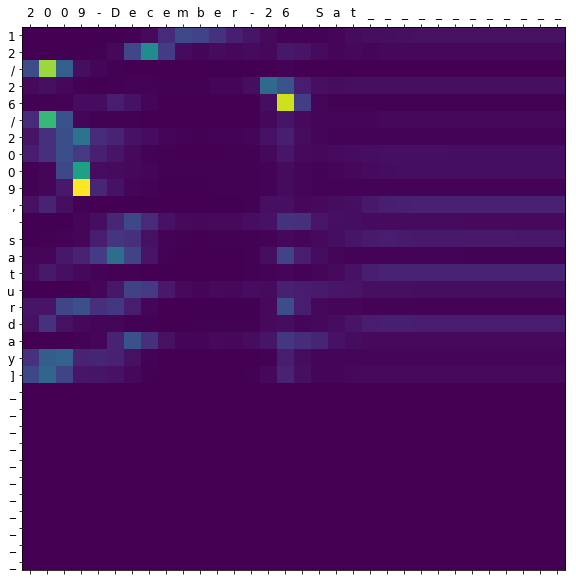

In [ ]:
q, a = gen_test(1)
result, sen, attention_plot = evaluate(q[0], encoder, decoder, char_indices, indices_char, in_seq_len, out_seq_len, enc_units, dec_units, context_units)
plot_attention(attention_plot, list(padding(sen, in_seq_len)), list(padding(result, out_seq_len)))